In [5]:
# ## Problems

import numpy as np
import numpy.fft as fp
from scipy import signal
import scipy.fftpack
from skimage.io import imread
from skimage.color import rgb2gray 
from skimage.metrics import peak_signal_noise_ratio
from scipy.ndimage import convolve
import cv2
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import LinearLocator, FormatStrFormatter

In [6]:
def plot_image(im, title):
    plt.imshow(im, cmap='gray')
    plt.axis('off')
    plt.title(title, size=20)

def plot_freq_spectrum(F, title, cmap=plt.cm.gray, show_axis=True, colorbar=False):
    plt.imshow((20*np.log10(0.1 + fp.fftshift(F))).real.astype(int), cmap=cmap)
    if not show_axis:
        plt.axis('off')
    if colorbar:
        plt.colorbar()
    plt.title(title, size=20)

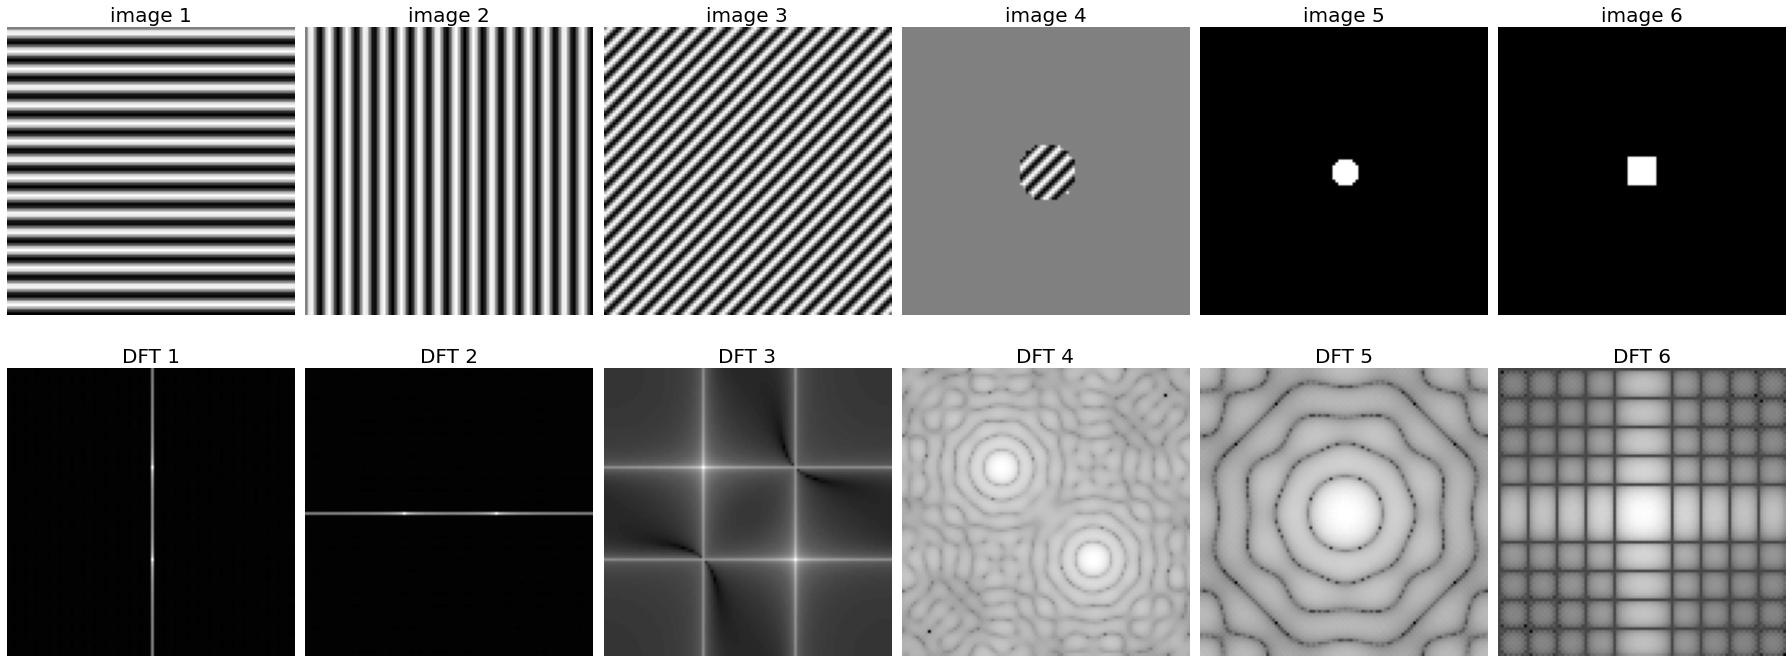

In [8]:
h, w = 100, 100
images = list()

im = np.zeros((h,w))
for x in range(h):
    im[x,:] = np.sin(x)
images.append(im)

im = np.zeros((h,w))
for y in range(w):
    im[:,y] = np.sin(y)
images.append(im)

im = np.zeros((h,w))
for x in range(h):
    for y in range(w):
        im[x,y] = np.sin(x + y) 
images.append(im)

im = np.zeros((h,w))
for x in range(h):
    for y in range(w):
        if (x-h/2)**2 + (y-w/2)**2 < 100:
            im[x,y] = np.sin(x + y) 
images.append(im)

im = np.zeros((h,w))
for x in range(h):
    for y in range(w):
        if (x-h/2)**2 + (y-w/2)**2 < 25:
            im[x,y] = 1 
images.append(im)

im = np.zeros((h,w))
im[h//2 -5:h//2 + 5, w//2 -5:w//2 + 5] = 1 
images.append(im)

plt.figure(figsize=(25,10))
i = 1
for im in images:
    plt.subplot(2,6,i), plot_image(im, 'image {}'.format(i))
    plt.subplot(2,6,i+6), plot_freq_spectrum(fp.fft2(im), 'DFT {}'.format(i), show_axis=False)
    i += 1
plt.tight_layout()
plt.show() 

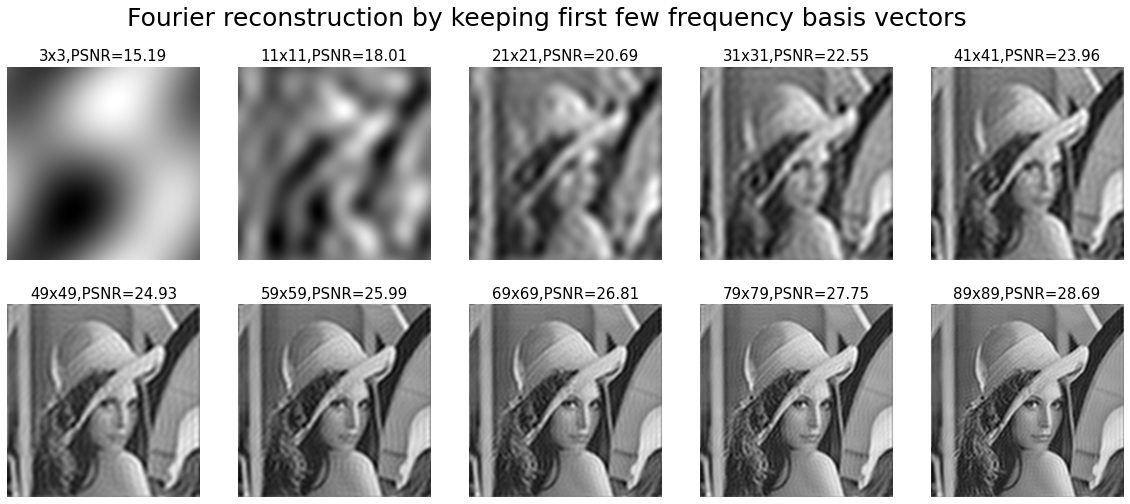

In [9]:
im = rgb2gray(imread("images/Chapter 03/images/img_03_01.jpg"))
h, w = im.shape
F = fp.fft2(im)
F_shifted = fp.fftshift(F)

xs = list(map(int, np.linspace(1, h//5, 10)))
ys = list(map(int, np.linspace(1, w//5, 10)))
plt.figure(figsize=(20,8))
plt.gray()
for i in range(10):
    F_mask = np.zeros((h, w))
    F_mask[h//2-xs[i]:h//2+xs[i]+1, w//2-ys[i]:w//2+ys[i]+1] = 1 
    F1 = F_shifted*F_mask
    im_out =  fp.ifft2(fp.ifftshift(F1)).real #np.abs()
    plt.subplot(2,5,i+1), plt.imshow(im_out), plt.axis('off')
    plt.title('{}x{},PSNR={}'.format(2*xs[i]+1, 2*ys[i]+1, round(peak_signal_noise_ratio(im, im_out),2)), size=15)
plt.suptitle('Fourier reconstruction by keeping first few frequency basis vectors', size=25)
plt.show()

## 1. Sampling to increase/decrease the resolution of an image

### 1.1. Up-sampling an image by using DFT and a Low-pass-filter (LPF)

(220, 220) (440, 440)


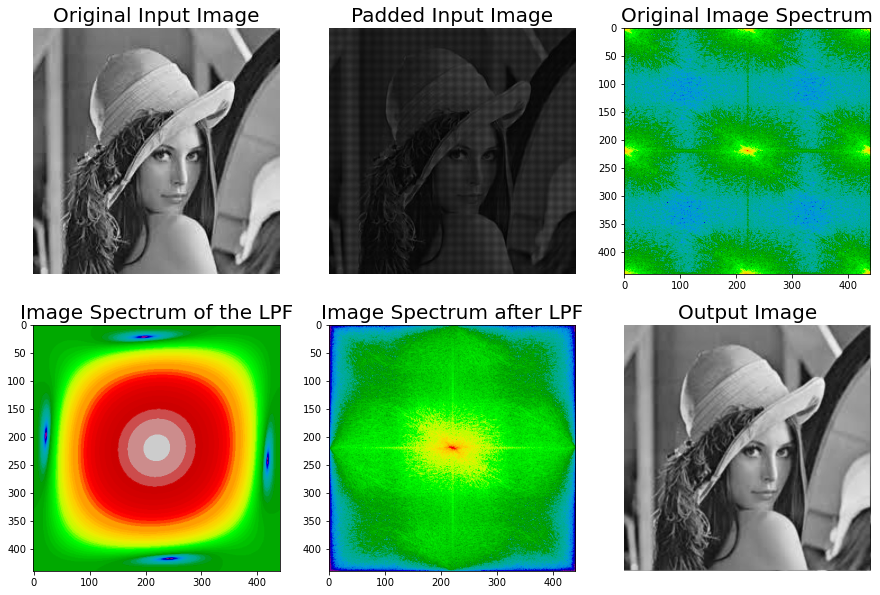

In [10]:
im = 255*rgb2gray(imread('images/Chapter 03/images/img_03_01.jpg'))
im1 = np.zeros((2*im.shape[0], 2*im.shape[1]))
print(im.shape, im1.shape)
for i in range(im.shape[0]):
    for j in range(im.shape[1]):
        im1[2*i,2*j] = im[i,j]

kernel = [[0.25, 0.5, 0.25], [0.5, 1, 0.5], [0.25, 0.5, 0.25]]

def pad_with_zeros(vector, pad_width, iaxis, kwargs):
    vector[:pad_width[0]] = 0
    vector[-pad_width[1]:] = 0
    return vector

kernel = np.pad(kernel, (((im1.shape[0]-3)//2,(im1.shape[0]-3)//2+1), ((im1.shape[1]-3)//2,(im1.shape[1]-3)//2+1)), pad_with_zeros) 

freq = fp.fft2(im1)
freq_kernel = fp.fft2(fp.ifftshift(kernel))

freq_LPF = freq*freq_kernel # by the Convolution theorem

im2 = fp.ifft2(freq_LPF).real

plt.figure(figsize=(15,10))
plt.gray() # show the filtered result in grayscale
cmap = 'nipy_spectral' #'viridis'
plt.subplot(231), plot_image(im, 'Original Input Image')
plt.subplot(232), plot_image(im1, 'Padded Input Image')
plt.subplot(233), plot_freq_spectrum(freq, 'Original Image Spectrum', cmap=cmap)
plt.subplot(234), plot_freq_spectrum(freq_kernel, 'Image Spectrum of the LPF', cmap=cmap)
plt.subplot(235), plot_freq_spectrum(fp.fft2(im2), 'Image Spectrum after LPF', cmap=cmap)
plt.subplot(236), plot_image(im2.astype(np.uint8), 'Output Image')
plt.show()



### 1.2. Down-sampling with Anti-Aliasing using Gaussian Filter

(480, 720, 3)


/var/folders/9v/jr20lh896vggl5_25dthcsw80000gn/T/ipykernel_52083/3773082916.py:7: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  im_blurred = gaussian(im, sigma=1.25, multichannel=True)


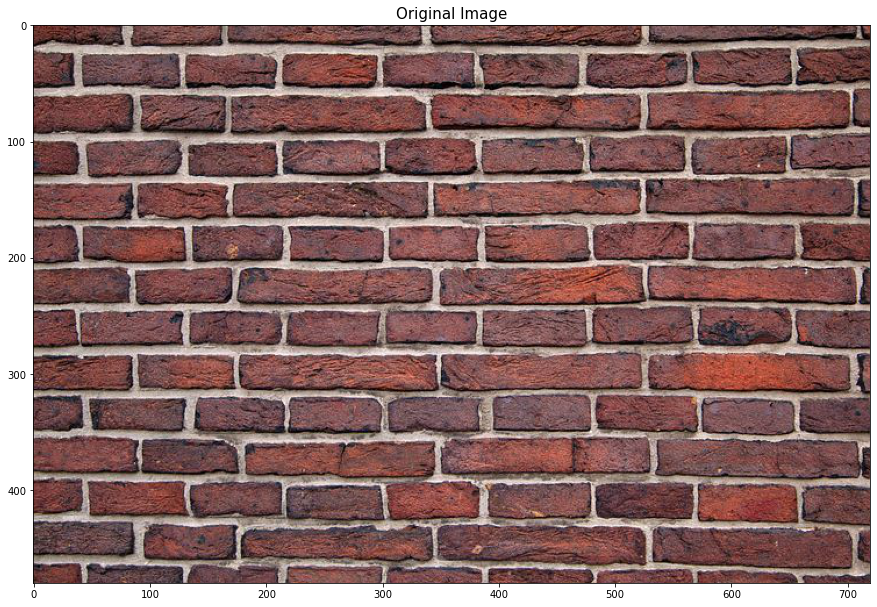

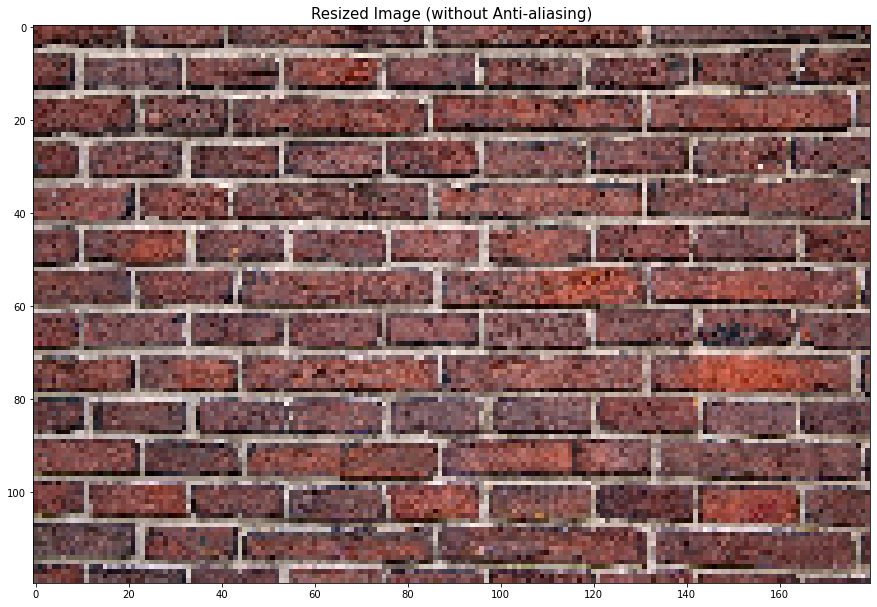

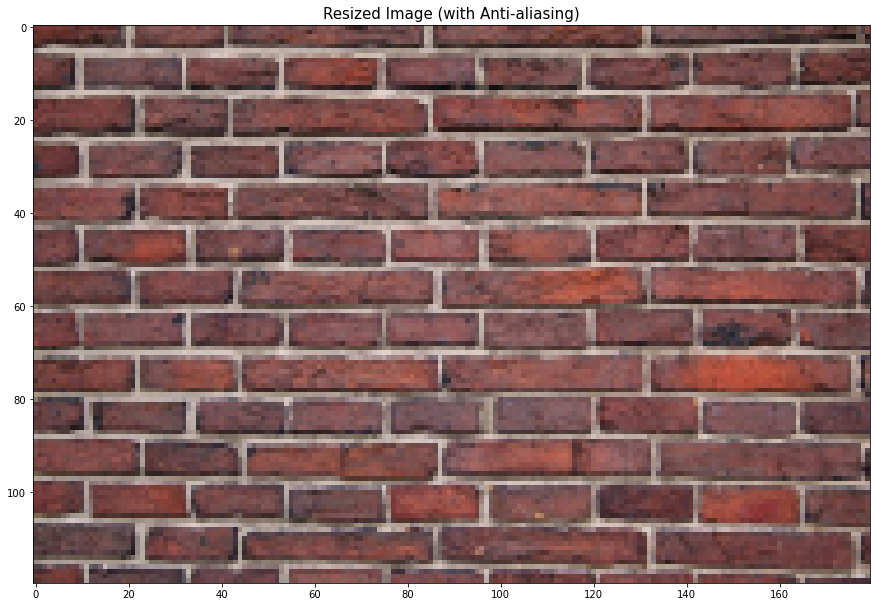

In [11]:

from skimage.filters import gaussian
from skimage import img_as_float
#im = rgb2gray(imread('images/Img_03_03.jpg'))
im = img_as_float(imread('images/Chapter 03/images/img_03_08.jpg'))
print(im.shape)

im_blurred = gaussian(im, sigma=1.25, multichannel=True) 

n = 4 # create and image 16 times smaller in size
h, w = im.shape[0] // n, im.shape[1] // n
im_small = np.zeros((h, w, 3))
for i in range(h):
   for j in range(w):
      im_small[i,j] = im[n*i, n*j]
im_small_aa = np.zeros((h, w, 3))
for i in range(h):
   for j in range(w):
      im_small_aa[i,j] = im_blurred[n*i, n*j]

plt.figure(figsize=(15,15))
plt.imshow(im), plt.title('Original Image', size=15)
plt.show()

plt.figure(figsize=(15,15))
plt.imshow(im_small), plt.title('Resized Image (without Anti-aliasing)', size=15)
plt.show()

plt.figure(figsize=(15,15))
plt.imshow(im_small_aa), plt.title('Resized Image (with Anti-aliasing)', size=15)
plt.show()

## 2. Denoising an Image with LPF/Notch filter in the Frequency domain

### 2.1 Removing Periodic Noise with Notch Filter

(380, 400)


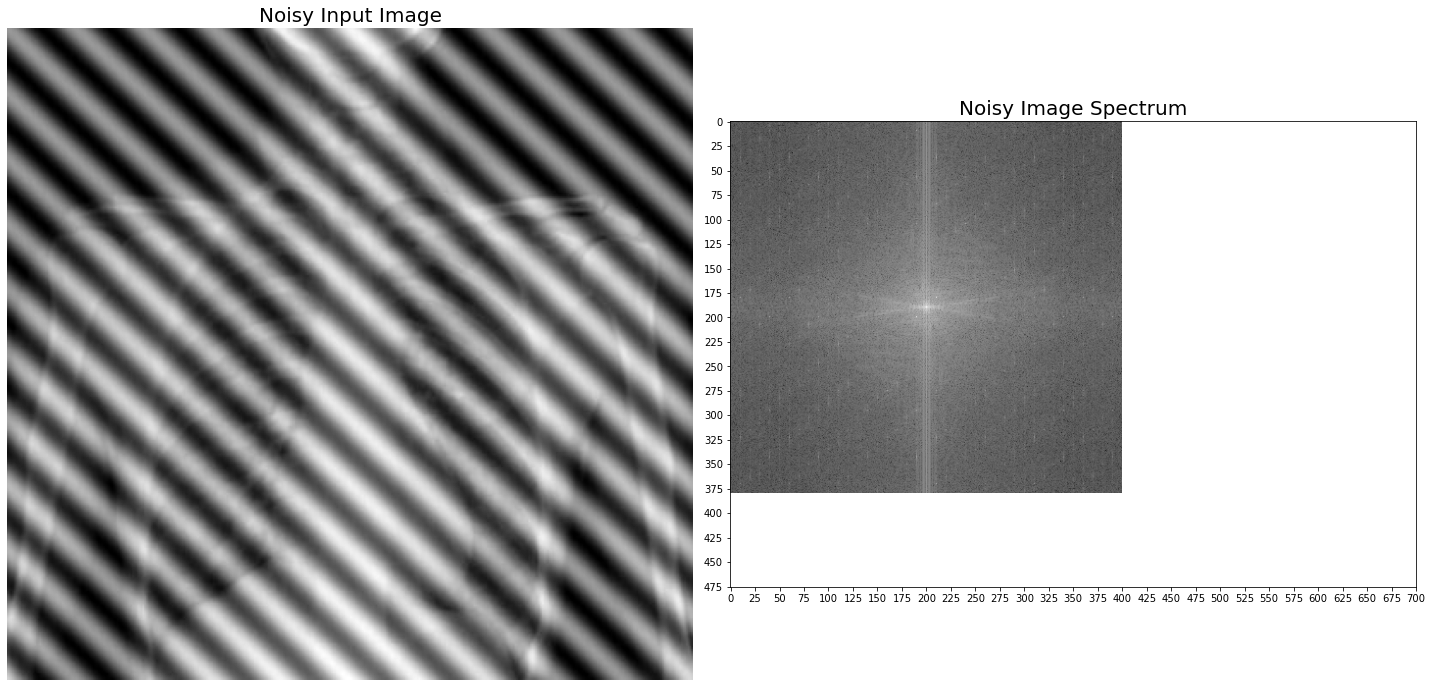

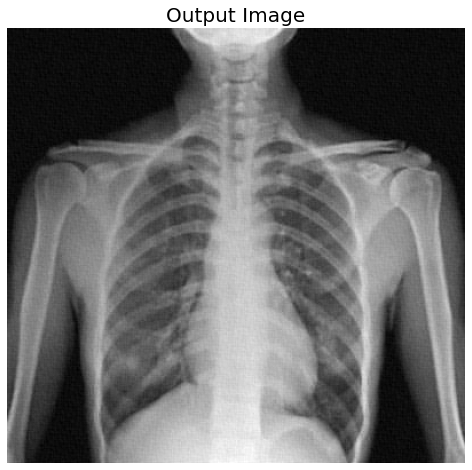

In [15]:
# im_noisy = rgb2gray(imread("images/Chapter 03/images/Img_03_23.jpg"))
im_noisy = imread("images/Chapter 03/images/Img_03_23.jpg")
F_noisy = fp.fft2((im_noisy))
print(F_noisy.shape)

def plot_freq_spectrum(F, title, cmap=plt.cm.gray):
    plt.imshow((20*np.log10(0.1 + fp.fftshift(F))).real.astype(int), cmap=cmap)
    plt.xticks(np.arange(0, im.shape[1], 25))
    plt.yticks(np.arange(0, im.shape[0], 25))
    plt.title(title, size=20)

plt.figure(figsize=(20,10))

plt.subplot(121), plot_image(im_noisy, 'Noisy Input Image')
plt.subplot(122), plot_freq_spectrum(F_noisy, 'Noisy Image Spectrum') 

plt.tight_layout()
plt.show()

F_noisy_shifted = fp.fftshift(F_noisy)
F_noisy_shifted[180,210] = F_noisy_shifted[200,190] = 0
im_out =  fp.ifft2(fp.ifftshift(F_noisy_shifted)).real #np.abs()

#print(signaltonoise(im1, axis=None))
plt.figure(figsize=(10,8))
plot_image(im_out, 'Output Image')
plt.show()

### 2.2 Removing salt-and-pepper noise using Gaussian LPF with scipy fftpack


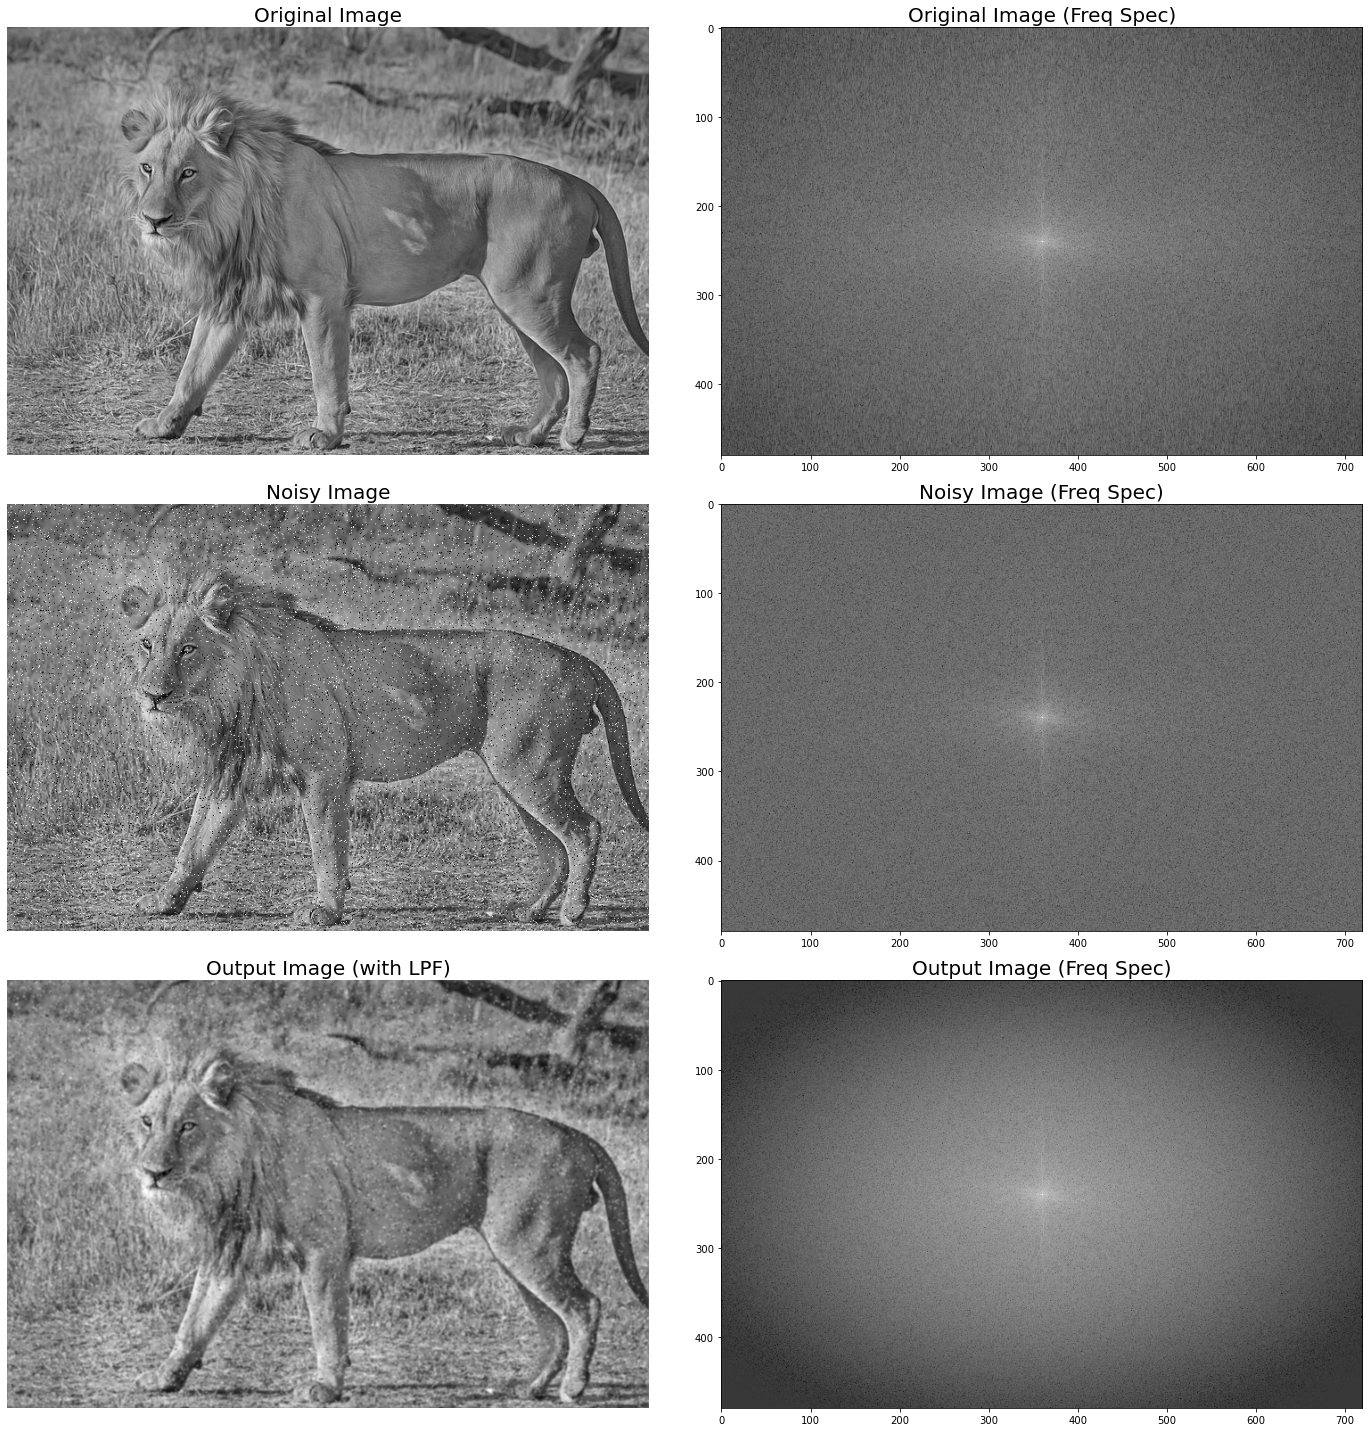

In [18]:
from scipy import ndimage
from scipy import fftpack
from skimage.util import random_noise

im = rgb2gray(imread('images/Chapter 03/images/Img_03_02.jpg'))
noisy = random_noise(im, mode='s&p')

im_freq = fftpack.fft2(im)
noisy_freq = fftpack.fft2(noisy)
sigma = 1 #0.1
noisy_smoothed_freq = ndimage.fourier_gaussian(noisy_freq, sigma=sigma)
noisy_smoothed = fftpack.ifft2(noisy_smoothed_freq)

fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(20,20))
plt.gray()  # show the filtered result in grayscale
ax1.imshow(im), ax1.axis('off'), ax1.set_title('Original Image', size=20)
ax2.imshow((20*np.log10(0.1 + fftpack.fftshift(im_freq))).real.astype(int))
ax2.set_title('Original Image (Freq Spec)', size=20)
ax3.imshow(noisy), ax3.axis('off'), ax3.set_title('Noisy Image', size=20)
ax4.imshow((20*np.log10( 0.1 + fftpack.fftshift(noisy_freq))).real.astype(int))
ax4.set_title('Noisy Image (Freq Spec)', size=20)

ax5.imshow(noisy_smoothed.real), ax5.axis('off'), ax5.set_title('Output Image (with LPF)', size=20)
ax6.imshow( (20*np.log10( 0.1 + fftpack.fftshift(noisy_smoothed_freq))).real.astype(int))
ax6.set_title('Output Image (Freq Spec)', size=20)
plt.tight_layout()
plt.show()